<a href="https://colab.research.google.com/github/E84081210/Test/blob/main/E94109010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


### This code applies Butterworth filter to purify audio resource.
### 這份程式碼利用 Butterworth 演算法，過濾聲音的雜訊

Install necessary Python modules. No environment issues as running on Colab.

安裝必要的 Python Module，由於是在 Colab 上運行，無環境問題。

In [ ]:
!pip install -q pytube pydub scipy ipywidgets
print("Successfully installed required packages.")

Code 01: Extract audio from YouTube and save it as “org_audio.mp3”. **Change desired URL in line 7, or apply default**

程式碼 01：從 Youtube 上擷取影片，並儲存為 "org_audio.mp3" **請在第七行更改 Youtube URL，或使用預設值**

In [ ]:
from pytube import YouTube
from pydub import AudioSegment, effects
import os
import time

# Default YouTube URL and audio filename
youtube_url = 'https://www.youtube.com/watch?v=JBcJOnmegv4'
audio_filename = "org_audio.mp3"

def download_audio(youtube_url, audio_filename=audio_filename):
    """
    Downloads audio from a YouTube video and saves it as an MP3 file.

    Parameters:
    youtube_url (str): The URL of the YouTube video.
    audio_filename (str): The filename to save the downloaded audio.

    This function uses the pytube library to download the audio stream
    from the provided YouTube URL. It then converts the downloaded audio
    file to MP3 format using pydub and saves it with the specified filename.
    """

    # Initialize YouTube object with the provided URL
    yt = YouTube(youtube_url)

    # Download the audio stream
    audio_stream = yt.streams.filter(only_audio=True).first()
    audio_path = audio_stream.download(filename='temp_audio')

    # Convert the downloaded audio file to .mp3 format
    audio = AudioSegment.from_file(audio_path)
    audio.export(audio_filename, format="mp3")

    # Clean up the temporary audio file
    os.remove(audio_path)

    # Print confirmation message
    print(f"Downloaded audio as {audio_filename}")

    # Wait for the audio file to be created
    wait_time = 50  # maximum wait time in seconds
    poll_interval = 0.5  # polling interval in seconds
    elapsed_time = 0

    while not os.path.exists(audio_filename) and elapsed_time < wait_time:
        time.sleep(poll_interval)
        elapsed_time += poll_interval

    # Check if the audio file has been successfully created
    if os.path.exists(audio_filename):
        print(f"{audio_filename} has been created successfully.")
    else:
        print(f"Failed to create {audio_filename} within {wait_time} seconds.")

# Example usage
download_audio(youtube_url)

Downloaded audio as org_audio.mp3
org_audio.mp3 has been created successfully.


程式碼02：利用 Butterworth 的高通（high-pass）和低通過濾

In [ ]:
from pydub import AudioSegment
from scipy.signal import butter, lfilter
import numpy as np

def butter_lowpass(cutoff_freq, sample_rate, order=4):
    """
    Design a Butterworth low-pass filter.

    Parameters:
    cutoff_freq (float): Cutoff frequency of the filter in Hz.
    sample_rate (int): Sampling rate of the audio in samples per second.
    order (int, optional): Order of the Butterworth filter. Default is 4.

    Returns:
    b (ndarray): Numerator coefficients of the filter.
    a (ndarray): Denominator coefficients of the filter.

    ODE-related explanation:
    The Butterworth low-pass filter is designed based on the differential equation
    of the analog prototype filter and then discretized for digital implementation.
    The normalized cutoff frequency normal_cutoff is used to calculate the filter
    coefficients b (numerator) and a (denominator).
    """
    # Calculate Nyquist frequency
    nyquist_freq = 0.5 * sample_rate

    # Normalize cutoff frequency
    normal_cutoff = cutoff_freq / nyquist_freq

    # Design Butterworth low-pass filter
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    return b, a

def butter_highpass(cutoff_freq, sample_rate, order=4):
    """
    Design a Butterworth high-pass filter.

    Parameters:
    cutoff_freq (float): Cutoff frequency of the filter in Hz.
    sample_rate (int): Sampling rate of the audio in samples per second.
    order (int, optional): Order of the Butterworth filter. Default is 4.

    Returns:
    b (ndarray): Numerator coefficients of the filter.
    a (ndarray): Denominator coefficients of the filter.

    ODE-related explanation:
    The Butterworth high-pass filter is designed based on the differential equation
    of the analog prototype filter and then discretized for digital implementation.
    The normalized cutoff frequency normal_cutoff is used to calculate the filter
    coefficients b (numerator) and a (denominator).
    """
    # Calculate Nyquist frequency
    nyquist_freq = 0.5 * sample_rate

    # Normalize cutoff frequency
    normal_cutoff = cutoff_freq / nyquist_freq

    # Design Butterworth high-pass filter
    b, a = butter(order, normal_cutoff, btype='high', analog=False)

    return b, a

def apply_filter(segment, b, a):
    """
    Apply a digital filter to an AudioSegment using given coefficients.

    Parameters:
    segment (AudioSegment): Input audio segment to filter.
    b (ndarray): Numerator coefficients of the filter.
    a (ndarray): Denominator coefficients of the filter.

    Returns:
    filtered_segment (AudioSegment): Filtered audio segment.

    This function applies the filter defined by coefficients b (numerator)
    and a (denominator) to the input audio segment using scipy's lfilter.
    """
    # Convert AudioSegment to numpy array
    samples = np.array(segment.get_array_of_samples())

    # Normalize audio samples
    normalized_samples = samples / (2 ** 15)

    # Apply filter to samples using ODE discretization
    filtered_samples = lfilter(b, a, normalized_samples)

    # Scale filtered samples back to int16 range
    filtered_samples = np.clip(filtered_samples * (2 ** 15), -2 ** 15, 2 ** 15 - 1)
    filtered_samples = filtered_samples.astype(np.int16)

    # Convert filtered samples back to AudioSegment
    filtered_segment = segment._spawn(filtered_samples)

    return filtered_segment

def low_pass_filter(segment, cutoff_freq=5000, sample_rate=44100):
    """
    Apply a Butterworth low-pass filter to an AudioSegment.

    Parameters:
    segment (AudioSegment): Input audio segment to filter.
    cutoff_freq (float, optional): Cutoff frequency of the low-pass filter in Hz. Default is 5000.
    sample_rate (int, optional): Sampling rate of the audio in samples per second. Default is 44100.

    Returns:
    filtered_segment (AudioSegment): Filtered audio segment.
    """
    b, a = butter_lowpass(cutoff_freq, sample_rate)
    return apply_filter(segment, b, a)

def high_pass_filter(segment, cutoff_freq=1000, sample_rate=44100):
    """
    Apply a Butterworth high-pass filter to an AudioSegment.

    Parameters:
    segment (AudioSegment): Input audio segment to filter.
    cutoff_freq (float, optional): Cutoff frequency of the high-pass filter in Hz. Default is 1000.
    sample_rate (int, optional): Sampling rate of the audio in samples per second. Default is 44100.

    Returns:
    filtered_segment (AudioSegment): Filtered audio segment.
    """
    b, a = butter_highpass(cutoff_freq, sample_rate)
    return apply_filter(segment, b, a)

def add_reverb(segment, delay_ms=100, decay=0.5, volume=-5):
    """
    Add a reverb effect to an AudioSegment.

    Parameters:
    segment (AudioSegment): Input audio segment to add reverb effect.
    delay_ms (int, optional): Delay time of the reverb effect in milliseconds. Default is 100.
    decay (float, optional): Decay factor of the reverb effect. Default is 0.5.
    volume (int, optional): Volume adjustment of the reverb effect in dB. Default is -5.

    Returns:
    reverb_segment (AudioSegment): Audio segment with reverb effect added.
    """
    # Convert AudioSegment to numpy array
    samples = np.array(segment.get_array_of_samples())

    # Normalize audio samples
    normalized_samples = samples / (2 ** 15)

    # Create reverb effect by adding delayed and decayed samples
    reverb_samples = np.zeros_like(normalized_samples)
    delay_samples = int(delay_ms * segment.frame_rate / 1000)

    for i in range(len(normalized_samples)):
        if i < delay_samples:
            reverb_samples[i] = normalized_samples[i]
        else:
            reverb_samples[i] = normalized_samples[i] + decay * normalized_samples[i - delay_samples]

    # Scale reverb samples back to int16 range
    reverb_samples = np.clip(reverb_samples * (2 ** 15), -2 ** 15, 2 ** 15 - 1)
    reverb_samples = reverb_samples.astype(np.int16)

    # Convert reverb samples back to AudioSegment
    reverb_segment = segment._spawn(reverb_samples)

    # Adjust volume
    reverb_segment = reverb_segment + volume

    return reverb_segment

def process_audio(input_filename, output_filename):
    """
    Process audio file by applying a high-pass filter followed by adding reverb effect.

    Parameters:
    input_filename (str): Filename of the input audio file.
    output_filename (str): Filename to save the processed audio file.

    This function loads the input audio file, applies a Butterworth high-pass filter,
    adds a reverb effect to the filtered audio, and exports the processed audio as an MP3 file.
    """
    # Load audio file
    audio_file = AudioSegment.from_file(input_filename)

    # Apply high-pass filter
    filtered_audio = high_pass_filter(audio_file)

    # Add reverb effect
    processed_audio = add_reverb(filtered_audio)

    # Export final audio
    processed_audio.export(output_filename, format="mp3")
    print(f"Processed audio exported as {output_filename} successfully.")

# Example usage
input_file = "org_audio.mp3"
output_file = "processed_audio.mp3"
process_audio(input_file, output_file)

Processed audio exported as processed_audio.mp3 successfully.


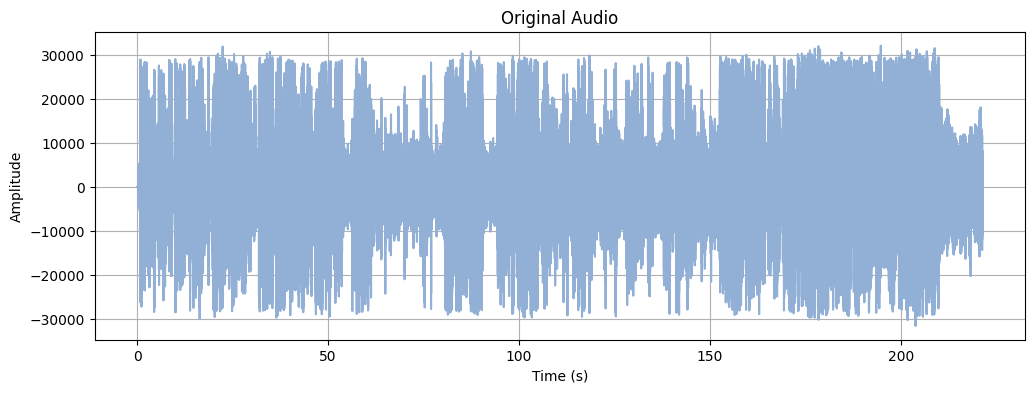

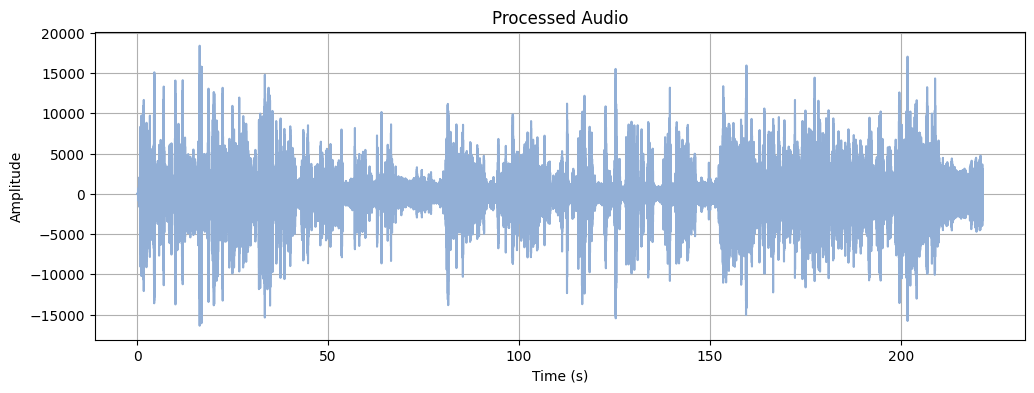

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment

def plot_waveform(audio_file, title):
    samples = np.array(audio_file.get_array_of_samples())
    sample_rate = audio_file.frame_rate

    # Calculate time array
    times = np.arange(len(samples)) / float(sample_rate)

    # Plot waveform
    plt.figure(figsize=(12, 4))
    plt.plot(times, samples, color='#92afd6')  # Adjusted color for consistency
    plt.title(title)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

# Load original audio file
audio_original = AudioSegment.from_file("org_audio.mp3")

# Load processed audio file
audio_processed = AudioSegment.from_file("processed_audio.mp3")

# Plot waveforms
plot_waveform(audio_original, "Original Audio")
plot_waveform(audio_processed, "Processed Audio")  # Adjusted title for processed audio